In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

with open('TIME.pkl','rb') as file:
    TIME = pickle.load(file)
    
data_dict = dict(subject=[], condition=[], trial=[], t=[], 
                 Md=[], r=[], y=[], Wr=[], d=[], u=[], u0=[] ,u1=[])

for s in TIME: # subject
    for c in TIME[s]: # condition
        N = len(TIME[s][c]['r']) # number of trials
        T = len(TIME[s][c]['r'][0]) # number of time points per trial
        first = True
        for v in TIME[s][c]: # variable
            for n in range(N): # trial
                array = TIME[s][c][v][n]
                if v=='d': # FIX shape of the 'd' variable
                    data_dict[v] += list(np.hstack(array))
                else:
                    data_dict[v] += list(array)
                if first: data_dict['trial'] += ([n]*T)
            first = False
                
        data_dict['subject'] += ([int(s[7:])]*T*N)
        data_dict['condition']+=([int(c[9:])]*T*N)
        data_dict['t'] += [*list(range(T))]*N

        
DF = pd.DataFrame(data_dict)
DF

,subject,condition,trial,t,Md,r,y,Wr,d,u,u0,u1
0,0,0,0,0,0.035239,-0.038752,-0.368560,0.095547,-0.033688,-0.026487,-6.607569e-19,-0.026487
1,0,0,0,1,0.034225,-0.036724,-0.370930,0.088499,-0.035834,-0.026487,3.604128e-19,-0.026487
2,0,0,0,2,0.033174,-0.034598,-0.373353,0.081059,-0.037627,-0.025007,-1.296485e-18,-0.025007
3,0,0,0,3,0.032085,-0.032386,-0.375831,0.073301,-0.039052,-0.025007,3.854415e-19,-0.025007
4,0,0,0,4,0.030955,-0.030101,-0.378364,0.065300,-0.040098,-0.025007,-5.706537e-19,-0.025007
...,...,...,...,...,...,...,...,...,...,...,...,...
2519995,14,6,3,2395,0.025599,0.107969,0.145850,-0.022525,-0.074719,-0.052141,-5.214086e-02,0.053418
2519996,14,6,3,2396,0.024532,0.110490,0.144367,-0.030520,-0.067764,-0.052476,-5.247611e-02,0.053418
2519997,14,6,3,2397,0.023382,0.112923,0.142738,-0.038356,-0.060136,-0.047336,-4.733560e-02,0.053418
2519998,14,6,3,2398,0.022161,0.115259,0.140987,-0.045984,-0.051897,-0.041078,-4.107758e-02,0.053418


# multimodal EMG + joystick experiment

CPHS paper


* $r$: reference
* $y$: output
* $d$: disturbance
* $u$: user input


$\ddot y = u+d-a\dot y$


* $u0$: EMG data
* $u1$: joystick data

* condition #2: equal weighting

In [2]:
DF.loc[:,'mse'] = (DF.r-DF.y)**2 
DF.loc[:,'effort'] = DF.u**2 
DF.loc[:,'effort_u0'] = DF.u0**2 
DF.loc[:,'effort_u1'] = DF.u1**2

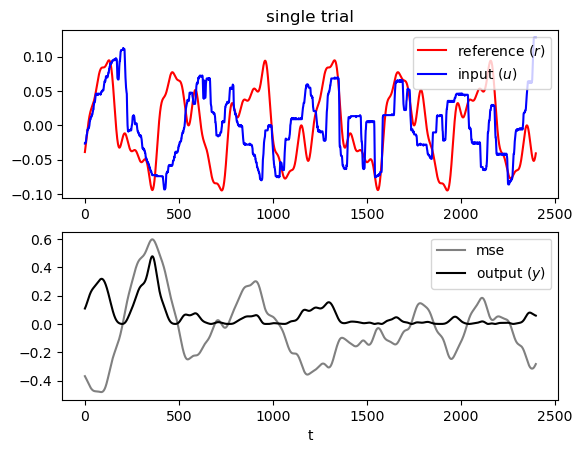

In [3]:
fig, axs = plt.subplots(nrows=2)

df = DF.groupby(['subject','condition','trial']).get_group((0,0,0))

COLOR_R = 'red'
COLOR_U = 'blue'
COLOR_Y = 'grey'
COLOR_E = 'black'

axs[0].plot(df.t, df.r, color=COLOR_R)
axs[0].plot(df.t, df.u, color=COLOR_U)
axs[0].legend(['reference ($r$)','input ($u$)'])
axs[1].plot(df.t, df.y, color=COLOR_Y)
axs[1].plot(df.t, df.mse, color=COLOR_E)
axs[1].legend(['mse','output ($y$)'])
axs[1].set(xlabel='t')
axs[0].set(title='single trial')

# plt.savefig('figure.svg', bbox_inches='tight')

Text(0, 0.5, 'mse')

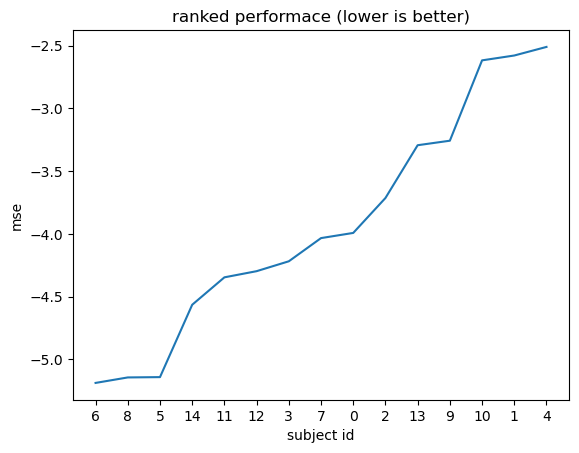

In [4]:
df = DF.groupby('subject').mean()
sort = np.log(df.mse.sort_values())
rank = [int(_) for _ in sort.index]

plt.plot(list(sort))
plt.xticks(range(len(sort)))
plt.gca().set_xticklabels(rank)
plt.title('ranked performace (lower is better)')
plt.xlabel('subject id')
plt.ylabel('mse')

Text(0.5, 1.0, 'mean squared error over trials')

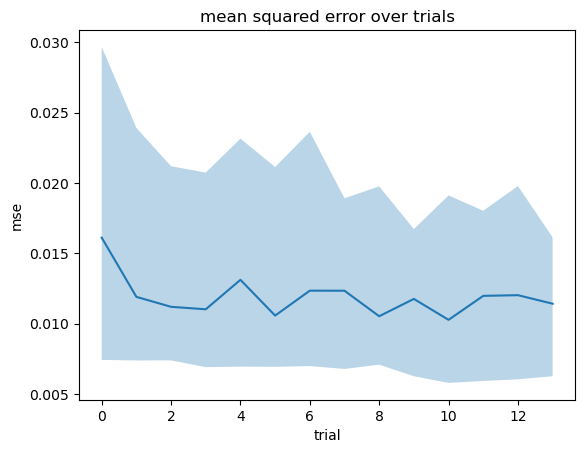

In [6]:

df = DF.groupby(['subject','condition','trial']).mean()
data_q1 = df.groupby('trial').mse.quantile([1/4])
data_q2 = df.groupby('trial').mse.quantile([2/4])
data_q3 = df.groupby('trial').mse.quantile([3/4])

plt.fill_between(range(len(data_q1)),list(data_q1),list(data_q3),alpha=0.3)
plt.plot(list(data_q2))
plt.xlabel('trial')
plt.ylabel('mse')
plt.title('mean squared error over trials')

Text(0.5, 1.0, 'mean squared error over time')

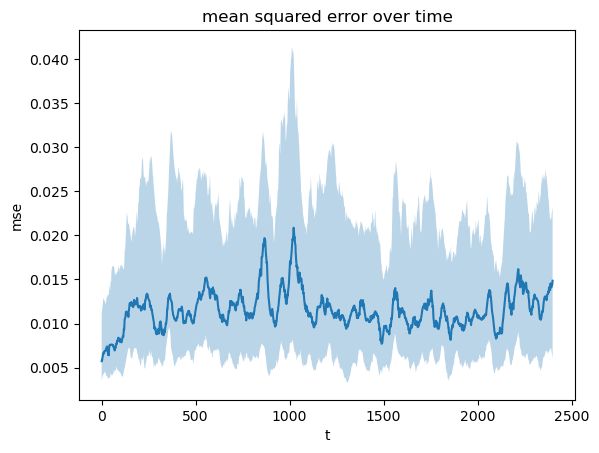

In [7]:
df = DF.groupby(['subject','condition','t']).mean()
data_q1 = df.groupby('t').mse.quantile([1/4])
data_q2 = df.groupby('t').mse.quantile([2/4])
data_q3 = df.groupby('t').mse.quantile([3/4])

plt.fill_between(range(len(data_q1)),list(data_q1),list(data_q3),alpha=0.3)
plt.plot(list(data_q2))
plt.xlabel('t')
plt.ylabel('mse')
plt.title('mean squared error over time')
#sns.lineplot(data=df, x='t',y='mse')

c:\Users\finleyh\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


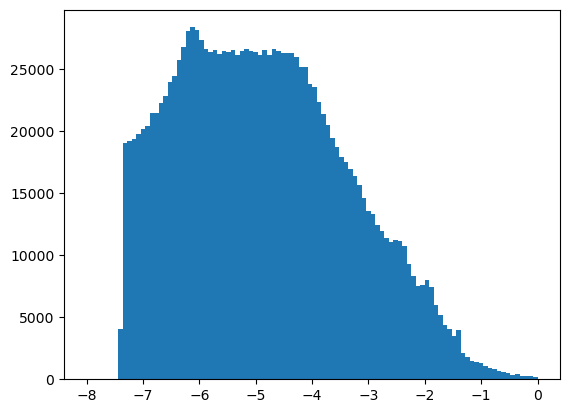

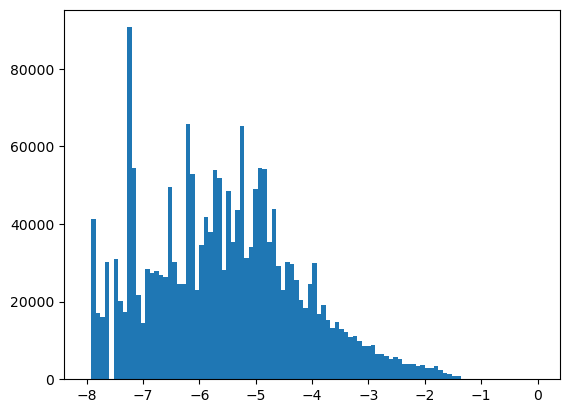

In [8]:
plt.hist(np.log(DF.effort_u0),range=[-8,0],bins=100)
plt.figure()
plt.hist(np.log(DF.effort_u1),range=[-8,0],bins=100)
pass

Text(0.5, 1.0, 'mean squared error per condition')

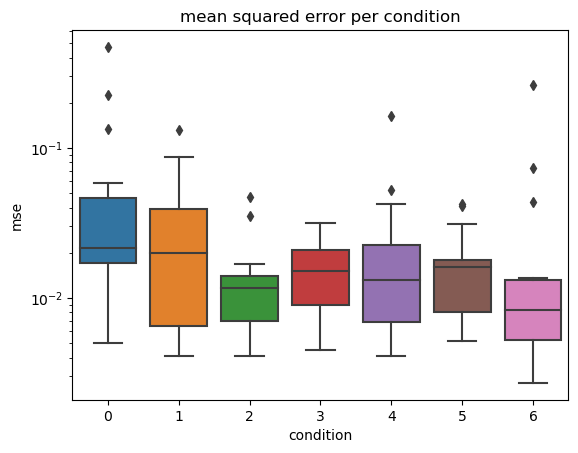

In [9]:
df = DF.groupby(['subject','condition']).mean().reset_index()
sns.boxplot(data=df,x='condition',y='mse')
plt.yscale('log')
plt.title('mean squared error per condition')

Text(0.5, 1.0, 'mean effort of per condition')

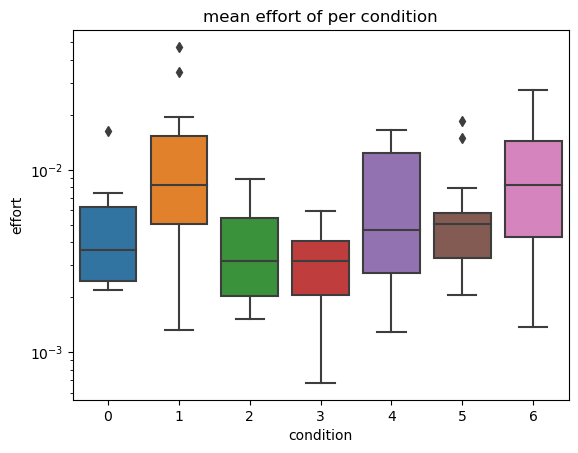

In [10]:
df = DF.groupby(['subject','condition']).mean().reset_index()
sns.boxplot(data=df,x='condition',y='effort')
plt.yscale('log')
plt.title('mean effort of per condition')

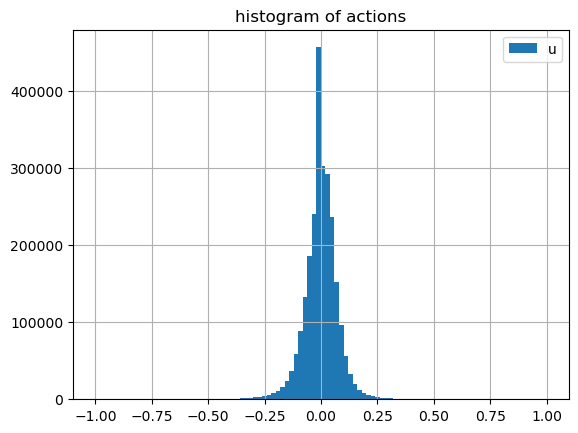

In [11]:
fig,ax = plt.subplots()
DF.hist('u',label='u',ax=ax,bins=100)
plt.title('histogram of actions')
plt.legend()

u0 vs u1


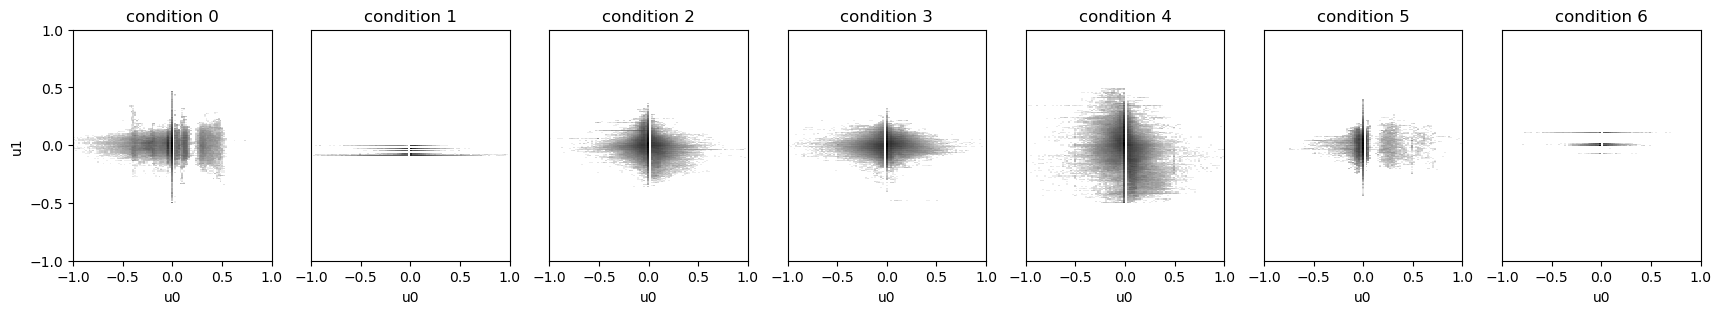

u0 vs y


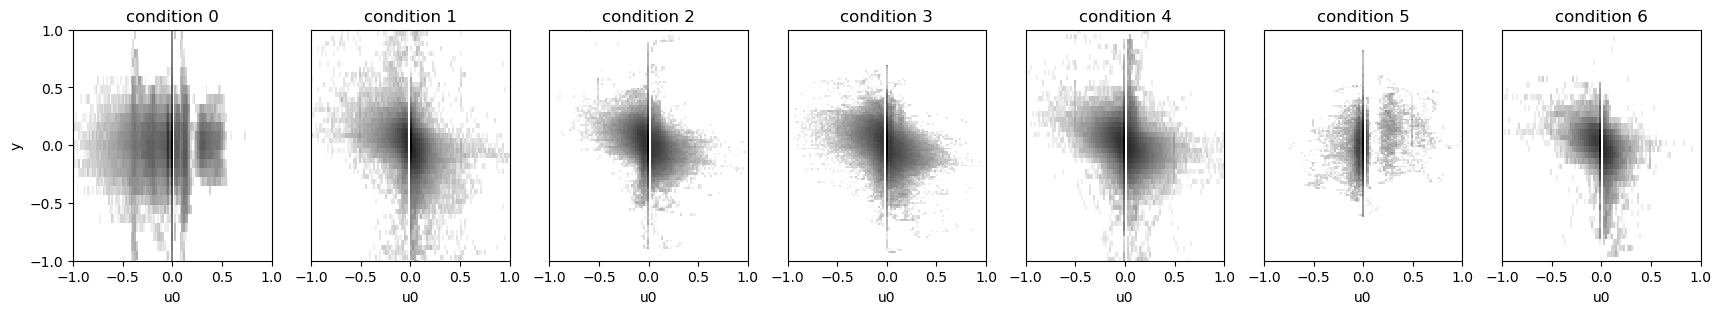

u1 vs y


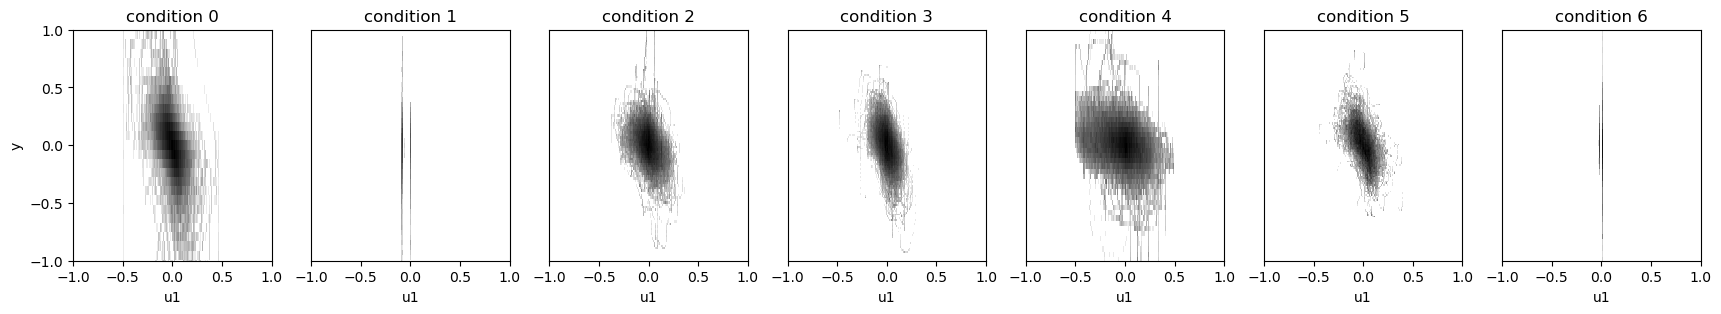

u vs d


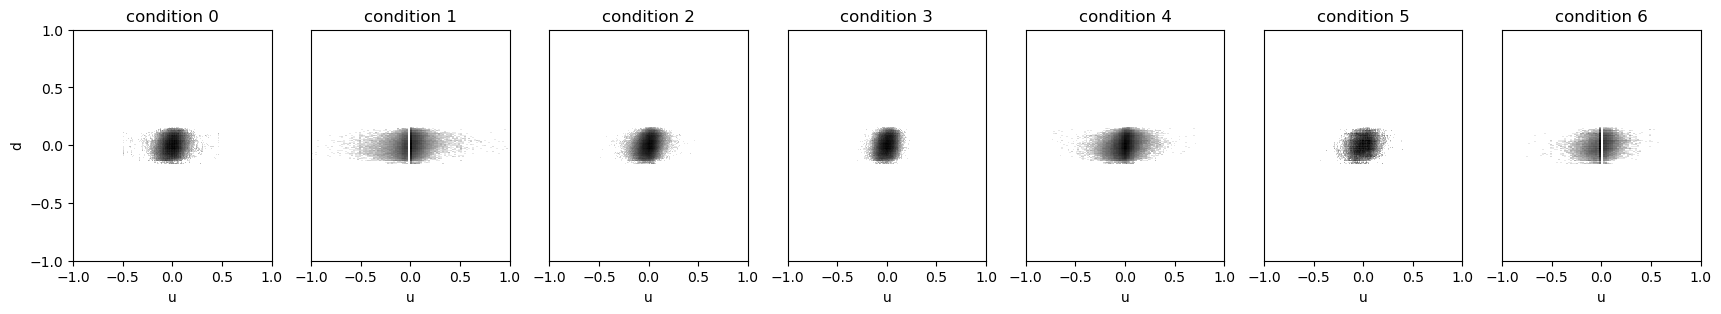

r vs y


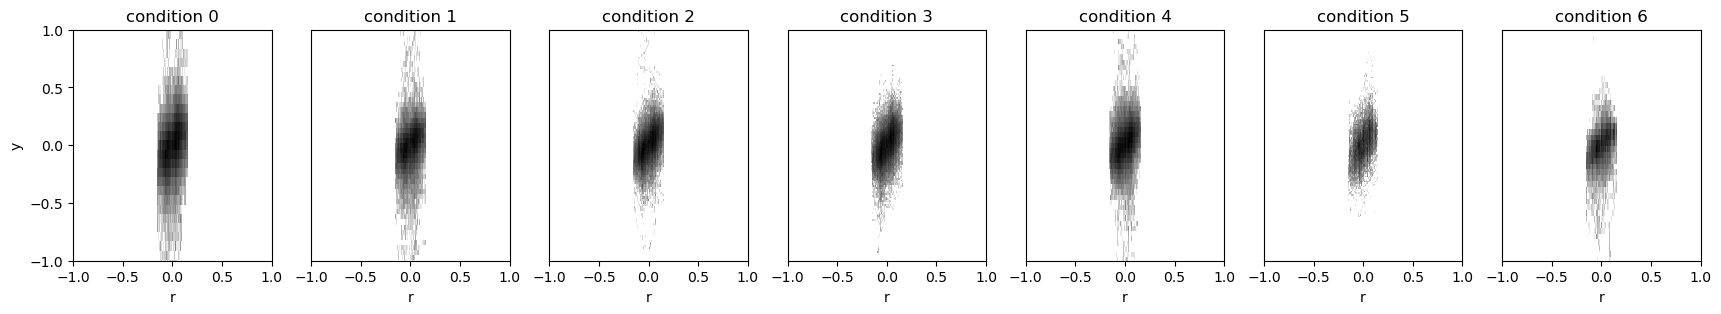

In [12]:
def plot_hist2d(x,y):
    print(x, 'vs', y)
    FIGSIZE=(8,8)

    fig, axs = plt.subplots(nrows=1,ncols=7,figsize=(3*7,3))

    for ax, condition in zip(axs, range(7)):
        df = DF.groupby('condition').get_group(condition)
        ax.hist2d(df[x], df[y], bins=100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.gray_r)
        ax.set(xlabel=x)
        ax.set(xticks=[-1,-.5,0,.5,1],yticks=[])
        ax.set(xlim=[-1,1],ylim=[-1,1])
        ax.set(title='condition '+str(condition))
    axs[0].set(ylabel=y,yticks=[-1,-.5,0,.5,1])
    plt.show()

plot_hist2d('u0','u1')
plot_hist2d('u0','y')
plot_hist2d('u1','y')
plot_hist2d('u','d')
plot_hist2d('r','y')
